
▶️  Batch 0: ['kate_ph_repeat']  (10 points)
   ✅  updated GP · total pts = 10 · kernel = HendersonHasselbalchKernel() + WhiteKernel(noise_level=0.0802)

▶️  Batch 1: ['charlie_ph', 'Sheet1']  (9 points)


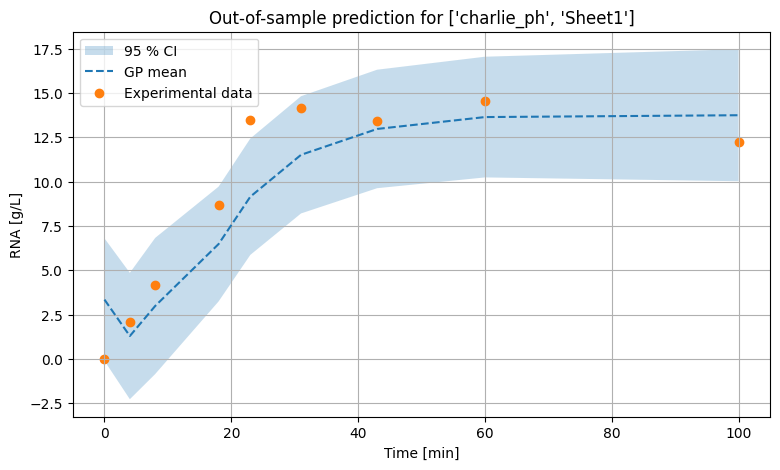

   ✅  updated GP · total pts = 19 · kernel = HendersonHasselbalchKernel() + WhiteKernel(noise_level=0.0802)

▶️  Batch 2: ['ricardo_ph', 'CSP HEPES']  (7 points)


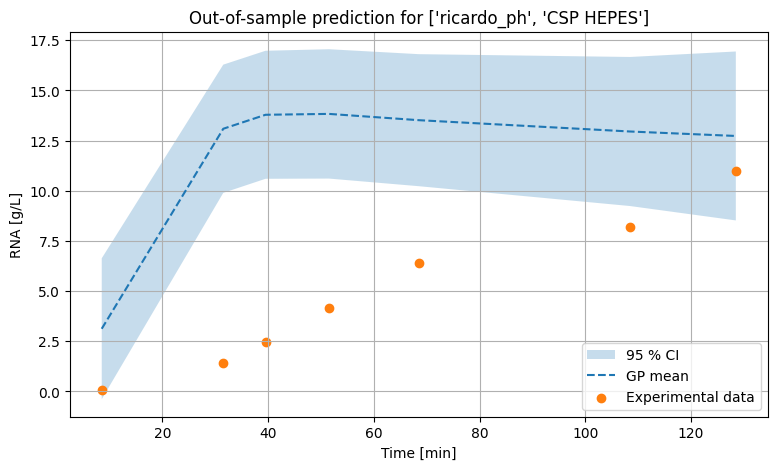

   ✅  updated GP · total pts = 26 · kernel = HendersonHasselbalchKernel() + WhiteKernel(noise_level=0.0802)

▶️  Batch 3: ['ricardo_ph', 'eGFP HEPES']  (11 points)


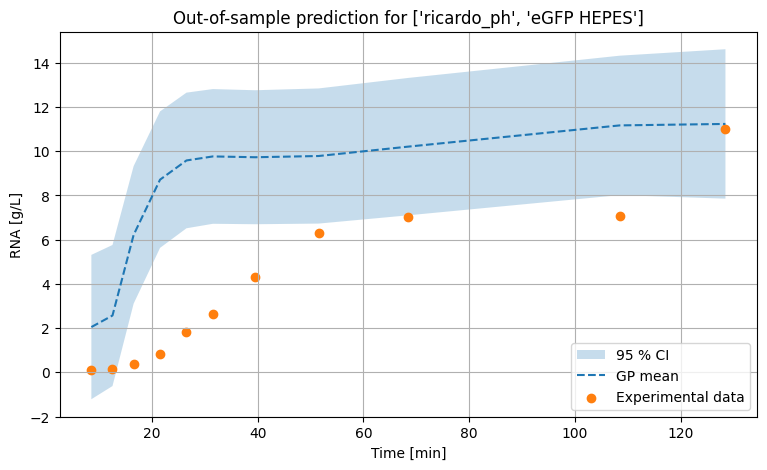

   ✅  updated GP · total pts = 37 · kernel = HendersonHasselbalchKernel() + WhiteKernel(noise_level=0.0802)

▶️  Batch 4: ['ricardo_ph', 'eGFP TRIS']  (11 points)


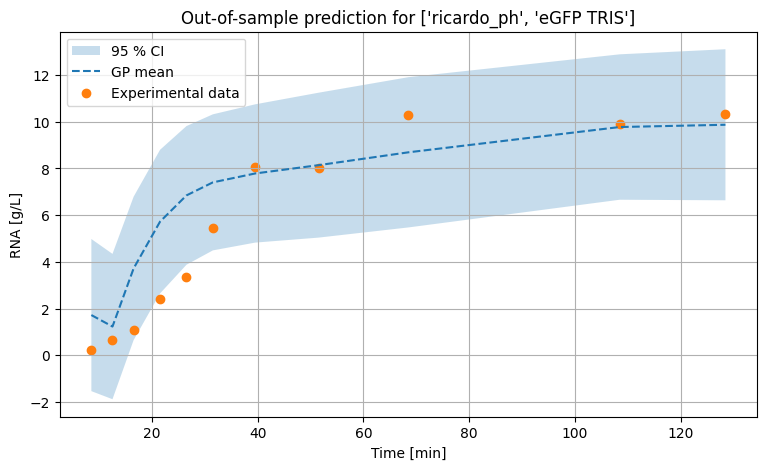

   ✅  updated GP · total pts = 48 · kernel = HendersonHasselbalchKernel() + WhiteKernel(noise_level=0.0802)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, RBF, WhiteKernel

# ← new custom kernel ---------------------------------------------------
from r3.models.custom_kernels.gp_henderson_hasselbalch_kernel import (
    HendersonHasselbalchKernel,
)

import r3.schema as schema
import r3.adapters as adapters

# ── columns ------------------------------------------------------------
X_cols = [schema.IVTReactionSchema.pH.value, schema.IVTReactionSchema.TIME_min.value]
y_cols = [schema.IVTReactionSchema.RNA_g_L.value]

# ── kernel prior -------------------------------------------------------
# Henderson–Hasselbalch kernel:
#     This kernel transforms the *pH* coordinate using the
#     Henderson–Hasselbalch equation before evaluating the underlying
#     base kernel.  We wrap a Constant × RBF kernel (one length‑scale per
#     input dimension) and append an independent WhiteKernel term to
#     capture observation noise.  The pKa hyper‑parameter can be left
#     free for the optimiser or fixed to a sensible buffer value.
# ----------------------------------------------------------------------
base_kernel = C(1.0, (1e-2, 1e3)) * RBF([1.0, 1.0], (1e-2, 1e3))
kernel_prior = HendersonHasselbalchKernel(base_kernel, pKa=7.2) + WhiteKernel(
    1e-2, (1e-5, 1)
)

# ── load experimental batches -----------------------------------------
exp_conds, responses = adapters.DataPipelineAdapter(
    "kate_ph_repeat", verbose=False
).get_all(
    X_columns=X_cols,
    y_columns=y_cols,
    paths=[
        ["charlie_ph", "Sheet1"],
        ["ricardo_ph", "CSP HEPES"],
        ["ricardo_ph", "eGFP HEPES"],
        ["ricardo_ph", "eGFP TRIS"],
    ],
)

# ── running objects ----------------------------------------------------
X_train_all, y_train_all = None, None  # cumulative data after each batch
gpr = None  # GP model updated iteratively

# ── sequential learning loop ------------------------------------------
for idx, (source, X_df) in enumerate(exp_conds):
    X_batch = X_df.values
    y_batch = responses[idx][1].values.flatten()

    print(f"\n▶️  Batch {idx}: {source}  ({len(y_batch)} points)")

    # 1️⃣ — FORECAST: predict current batch before learning from it
    if gpr is not None:
        y_mean, y_std = gpr.predict(X_batch, return_std=True)

        plt.figure(figsize=(9, 5))
        plt.fill_between(
            X_batch[:, 1],
            y_mean - 1.96 * y_std,
            y_mean + 1.96 * y_std,
            alpha=0.25,
            label="95 % CI",
        )
        plt.plot(X_batch[:, 1], y_mean, "--", label="GP mean")
        plt.scatter(X_batch[:, 1], y_batch, c="tab:orange", label="Experimental data")
        plt.title(f"Out-of-sample prediction for {source}")
        plt.xlabel("Time [min]")
        plt.ylabel("RNA [g/L]")
        plt.legend()
        plt.grid()
        plt.show()

    # 2️⃣ — LEARN: append the batch and refit the GP
    X_train_all = X_batch if X_train_all is None else np.vstack([X_train_all, X_batch])
    y_train_all = y_batch if y_train_all is None else np.hstack([y_train_all, y_batch])

    # Build a new regressor whose *prior kernel* is last round’s posterior kernel
    if gpr is None:  # first batch → optimise hyper‑parameters
        gpr = GaussianProcessRegressor(
            kernel=kernel_prior, normalize_y=True, n_restarts_optimizer=5
        )
    else:  # subsequent batches → freeze θ (posterior ⇒ prior)
        gpr = GaussianProcessRegressor(
            kernel=gpr.kernel_, normalize_y=True, optimizer=None
        )

    gpr.fit(X_train_all, y_train_all)
    print(
        f"   ✅  updated GP · total pts = {len(y_train_all)} · kernel = {gpr.kernel_}"
    )